In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.numpy.linalg import slogdet
from jax.scipy.stats import multivariate_normal as mvtn
import matplotlib.pyplot as plt
import numpy as np
from t import t_logpdf
# from tqdm import tqdm
from jax_tqdm import scan_tqdm

/home/jannis/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# bivariate normal model
def log_pdf(xp, yp, m, n, a, b, c):
    mean = jnp.array([m, n])
    U = jnp.array([[a, b], [0, c]])
    return mvtn.logpdf(jnp.array([xp, yp]), mean, U @ U.T)

def sample(key, m, n, a, b, c):
    mean = jnp.array([m, n])
    U = jnp.array([[a, b], [0, c]])
    return jax.random.multivariate_normal(key, mean, U @ U.T)

In [3]:
# predictive procedures
@jax.jit
def log_pred(xp, yp, x, y):
    assert len(x) == len(y)
    o = len(y)
    cons = jnp.log(o-2) - jnp.log(2*jnp.pi) + (o-1)/2*jnp.log(o+1) - (o-2)/2*jnp.log(o)
    ones = jnp.ones((o,))
    Gxy1 = jnp.vstack((x, y, ones)) @ jnp.vstack((x, y, ones)).T
    Gy1 = jnp.vstack((y, ones)) @ jnp.vstack((y, ones)).T
    xp, yp = jnp.hstack((x, xp)), jnp.hstack((y, yp))
    onesp = jnp.ones((o + 1,))
    Gxy1p = jnp.vstack((xp, yp, onesp)) @ jnp.vstack((xp, yp, onesp)).T
    Gy1p = jnp.vstack((yp, onesp)) @ jnp.vstack((yp, onesp)).T
    cons_xy = slogdet(Gy1)[1] + (o-2)/2*slogdet(Gxy1)[1]
    main = -(o-1)/2*slogdet(Gxy1p)[1] - slogdet(Gy1p)[1]
    return cons + cons_xy + main

def log_pred_ij(xp, yp, x, y):
    assert len(x) == len(y)
    n = len(y)
    X = jnp.vstack((x, y))
    xyp = jnp.array([xp, yp])
    mean = jnp.mean(X, 1)
    S = (n-1) * jnp.cov(X)
    return t_logpdf(xyp, mean, (n+1)*S/(n*(n-2)), n-2)

def log_pred_j(xp, yp, x, y):
    assert len(x) == len(y)
    n = len(y)
    X = jnp.vstack((x, y))
    xyp = jnp.array([xp, yp])
    mean = jnp.mean(X, 1)
    S = (n-1) * jnp.cov(X)
    return t_logpdf(xyp, mean, (n+1)*S/(n*(n-1)), n-1)

@jax.jit
def log_pred_plug_in(xp, yp, x, y, ddof):
    assert len(x) == len(y)
    X = jnp.vstack((x, y))
    xyp = jnp.array([xp, yp])
    mean = jnp.mean(X, 1)
    S = jnp.cov(X, ddof=ddof)
    return mvtn.logpdf(xyp, mean, S)

In [4]:
# numerically evaluate predictive procedures against knowing true parameters
n_observations = 4
@jax.jit
def mc_estimate_risk(key, m, n, a, b, c):
    samples = jax.vmap(sample, (0, None, None, None, None, None))(jax.random.split(key, n_observations+1), m, n, a, b, c)
    xp, yp = samples[0, 0], samples[0, 1]
    x, y = samples[1:, 0], samples[1:, 1]
    # return log_pred(xp, yp, x, y) - log_pred(yp, xp, y, x)
    # return log_pred(xp, yp, x, y) - log_pred_plug_in(xp, yp, x, y)
    return jnp.array([
        # log_pdf(xp, yp, m, n, a, b, c) - log_pred(xp, yp, x, y),
        # log_pdf(xp, yp, m, n, a, b, c) - log_pred_ij(xp, yp, x, y),
        # log_pdf(xp, yp, m, n, a, b, c) - log_pred_j(xp, yp, x, y),
        log_pdf(xp, yp, m, n, a, b, c) - log_pred_plug_in(xp, yp, x, y, 1),
        log_pdf(xp, yp, m, n, a, b, c) - log_pred_plug_in(xp, yp, x, y, 0)])

samples = 2 ** 16
iters = 2 ** 16

@scan_tqdm(iters)
def step(key, iter):
    key_now, key = jax.random.split(key, 2)
    keys = jax.random.split(key_now, samples)
    results = jax.vmap(mc_estimate_risk, (0, None, None, None, None, None))(keys, -3, -2, 5, 2, 2)
    mc_mean = jnp.nanmean(results, axis=0) 
    nans = jnp.sum(jnp.isnan(results), axis=0)
    return key, (iter, mc_mean, nans)
_, (_, mc_means, nans) = jax.lax.scan(step, jax.random.PRNGKey(0), jnp.arange(iters))
print(jnp.mean(mc_means, axis=0), jnp.sqrt(jnp.nanvar(mc_means, axis=0, ddof=1) / iters), jnp.sum(nans, axis=0))

# print("{0:.3g}".format(jnp.nanmean(result)), "{0:.3g}".format(jnp.mean(jnp.isnan(result))))

/home/jannis/miniconda3/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/jannis/miniconda3/lib/python3.11/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
Running for 65,536 iterations: 100%|██████████| 65536/65536 [05:59<00:00, 182.55it/s]


[36.95023718 49.53791713] [1.41085372 1.88113862] [0 0]


n=3 Running for 4,096 iterations: 100%|██████████| 4096/4096 [03:10<00:00, 21.49it/s]
[1.32434955e+00 1.71066847e+00 2.01759125e+00 1.39213200e+09 1.98288696e+09] [9.74781950e-05 1.25510649e-04 1.80948973e-04 9.09908418e+08 1.30709135e+09] [0 1 0 0 1]
Running for 65,536 iterations: 100%|██████████| 65536/65536 [05:39<00:00, 193.03it/s]
[2.26604883e+09 1.35916353e+09] [1.35979533e+09 4.64351029e+08] [16 19]

n=4 Running for 4,096 iterations: 100%|██████████| 4096/4096 [03:15<00:00, 20.93it/s]
[ 0.8391027   0.95283004  1.0473921  36.6890154  49.18963443] [7.89219335e-05 8.79552342e-05 1.13357822e-04 3.63729461e+00 4.84972653e+00] [0 0 0 0 0]
Running for 65,536 iterations: 100%|██████████| 65536/65536 [05:59<00:00, 182.55it/s]
[36.95023718 49.53791713] [1.41085372 1.88113862] [0 0]

n=5 Running for 4,096 iterations: 100%|██████████| 4096/4096 [01:05<00:00, 62.24it/s]
[0.62021384 0.67316256 0.71880181 3.33573045 4.31238142] [6.87494622e-05 7.37714568e-05 8.98919485e-05 8.27806779e-03 1.03483010e-02] [0 0 0 0 0]

n=6 Running for 4,096 iterations: 100%|██████████| 4096/4096 [01:06<00:00, 61.24it/s]
[0.49370389 0.52408233 0.55095814 1.56464247 1.96591502] [5.99446749e-05 6.24700095e-05 7.33867474e-05 7.21773957e-04 8.69108897e-04] [0 0 0 0 0]

n=7 Running for 4,096 iterations: 100%|██████████| 4096/4096 [01:08<00:00, 59.50it/s]
[0.41058143 0.43021788 0.44788926 0.99976261 1.2265033 ] [5.56435790e-05 5.73146566e-05 6.54256602e-05 2.74851656e-04 3.24299130e-04] [0 0 0 0 0]

n=8 Running for 4,096 iterations: 100%|██████████| 4096/4096 [01:10<00:00, 57.91it/s]
[0.35178936 0.36550335 0.37802397 0.72889725 0.87660843] [4.99253683e-05 5.12718668e-05 5.76997583e-05 1.75167950e-04 2.03526223e-04] [0 0 0 0 0]

n=9 Running for 4,096 iterations: 100%|██████████| 4096/4096 [01:12<00:00, 56.86it/s]
[0.30781415 0.31790449 0.32722792 0.57099106 0.67541702] [4.81786921e-05 4.91307169e-05 5.45644116e-05 1.32015969e-04 1.51614967e-04] [0 0 0 0 0]

n=10 Running for 4,096 iterations: 100%|██████████| 4096/4096 [01:13<00:00, 55.47it/s]
[0.2738083  0.28156356 0.28878777 0.4685758  0.54656838] [4.45491908e-05 4.54943621e-05 5.01095417e-05 1.07275034e-04 1.21949541e-04] [0 0 0 0 0]

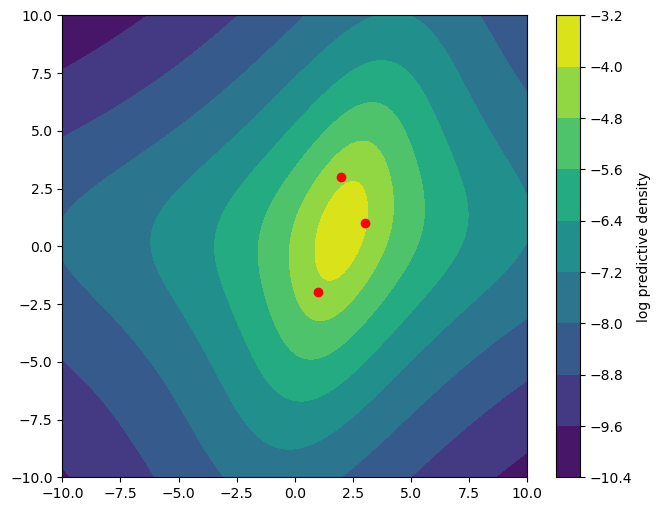

In [5]:
# visualize the predictive density
x = jnp.array([1, 2, 3], float)
y = jnp.array([-2, 3, 1], float)
X = jnp.vstack((x, y))
mean = jnp.mean(X, 1)

xpts = np.linspace(-10, 10, 500)
ypts = np.linspace(-10, 10, 500)
X, Y = np.meshgrid(xpts, ypts)

# Compute the function values
def f(xp, yp):
    return log_pred(xp, yp, x, y)
    # uncomment to use the predictive procedure in a different basis
    # return log_pred(xp, xp + yp, x, x + y)
    # return log_pred(xp + yp, yp, x + y, y)
    # return jnp.exp(log_pred(xp, yp, y, x))
Z = jax.vmap(jax.vmap(f, (0, 0)), (0, 0))(X, Y)

plt.figure(figsize=(7.5, 6))
contour = plt.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(contour, label='log predictive density')

plt.scatter(x, y, c='red')
plt.show()
# plt.savefig('figures/mine_test2.pdf', transparent=True, bbox_inches='tight', pad_inches=0)